In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 운영 체제 정보를 확인하고, matplotlib을 사용하여 그래프 그릴 준비하기
import platform
import matplotlib.pyplot as plt

%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"

from matplotlib import font_manager, rc
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Sorry')

plt.rcParams['axes.unicode_minus'] = False

In [2]:
import tensorflow as tf
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0], [4.0, 5.0]])

In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version: 2.6.0
GPU is available


In [8]:
import gymnasium as gym

env = gym.make('CartPole-v1', render_mode='rgb_array')

In [10]:
obs, info = env.reset(seed=42)
print(obs)
print(info)

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
{}


In [16]:
img = env.render()
img.shape  # 높이, 너비, 채널 (3 = 빨강, 초록, 파랑)

(400, 600, 3)

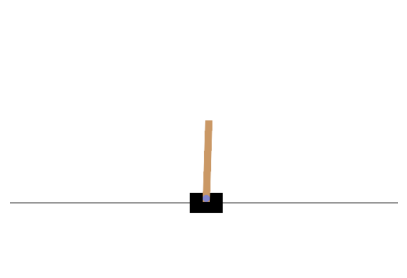

In [17]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [18]:
env.action_space

Discrete(2)

In [19]:
action = 1 # 오른쪽으로 가속
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

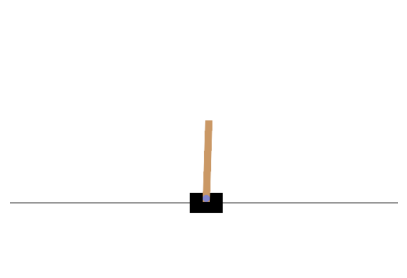

In [20]:
plot_environment(env)
plt.show()

In [21]:
print(reward)
print(done)
print(truncated)
print(info)

1.0
False
False
{}


In [22]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
            
    totals.append(episode_rewards)

In [23]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

In [29]:
import matplotlib.animation
from IPython.display import HTML

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

# 애니메이션 생성 및 표시
animation = show_one_episode(basic_policy)
HTML(animation.to_jshtml())

In [32]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [33]:
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
animation = show_one_episode(pg_policy)
HTML(animation.to_jshtml())

In [43]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
        
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [41]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
                
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
        
    return all_rewards, all_grads

In [36]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                             for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
           for discounted_rewards in all_discounted_rewards]

In [37]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [38]:
discount_and_normalize_rewards([[10, 0, -50],[10, 20]],
                              discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [39]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [45]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                      discount_factor)
    
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [46]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [47]:
Q_values = np.full((3, 3), -np.inf)  # 불가능한 동작의 경우 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 가능한 모든 행동

In [48]:
gamma = 0.90  # 할인 계수

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)

In [49]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [50]:
Q_values.argmax(axis=1)  # 각 상태에 대한 최적의 행동

array([0, 0, 1], dtype=int64)

In [52]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [53]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [62]:
alpha0 = 0.05 # 초기 학습률
decay = 0.005 # 학습률 감쇠
gamma = 0.90 # 할인 계수
state = 0 # 초기 상태

for iteration in range(10_000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max() # 다음 스텝에서 탐욕적 정책
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

In [63]:
tf.random.set_seed(42)

input_shape = [4]
n_outputs = 2

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    tf.keras.layers.Dense(32, activation='elu'),
    tf.keras.layers.Dense(n_outputs)
])

In [64]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # 랜덤 행동
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax() # DQN에 따른 최적의 행동

In [65]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [74]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ] # [상태, 행동, 보상, 다음 상태, 종료 여부, 중지 여부]

In [70]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [80]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds) # 에피소드가 중지되거나 종료되지 않음
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [81]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break
            
    if episode > 50:
        training_step(batch_size)

In [83]:
animation = show_one_episode(epsilon_greedy_policy)
HTML(animation.to_jshtml())

In [84]:
# 이전과 동일한 DQN 모델을 생성.

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

In [85]:
target = tf.keras.models.clone_model(model) # 모델 구조 복사
target.set_weights(model.get_weights()) # 가중치 복사

In [86]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

replay_buffer = deque(maxlen=2000)  # 재생 버퍼를 초기화

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states, verbose=0)  # <= 변경됨
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # 에피소드가 완료되지 않거나 중단되지 않음
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [87]:
# 에피소드 횟수를 600에서 300으로 줄임.
for episode in range(300):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # 디버그 정보를 표시하고, 다음 그림을 위한 데이터를 저장하며,
    # 지금까지 최고의 모델 가중치를 추적.
    print(f"\r에피소드: {episode + 1}, 스텝: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:                        # <= 변경됨
            target.set_weights(model.get_weights())  # <= 변경됨


model.set_weights(best_weights)  # 최상의 모델 가중치를 복원.

에피소드: 300, 스텝: 9, eps: 0.40248

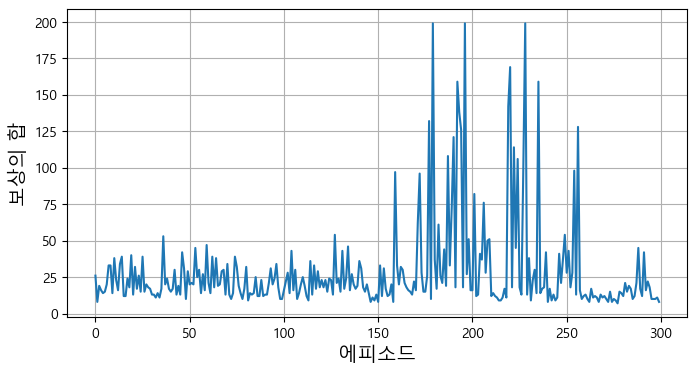

In [88]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("에피소드", fontsize=14)
plt.ylabel("보상의 합", fontsize=14)
plt.grid(True)
plt.show()

In [89]:
animation = show_one_episode(epsilon_greedy_policy)
HTML(animation.to_jshtml())

In [99]:
# 더블 DQN
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)  # 모델의 아키텍처 복제
target.set_weights(model.get_weights())  # 가중치 복사

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    #################### 변경된 섹션 ####################
    next_Q_values = model.predict(next_states, verbose=0)  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)
    #########################################################

    runs = 1.0 - (dones | truncateds)  # 에피소드가 완료되지 않거나 중단되지 않음
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

# 에피소드 횟수를 600에서 300으로 감소.
for episode in range(300):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\r에피소드: {episode + 1}, 스텝: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

에피소드: 300, 스텝: 13, eps: 0.4020

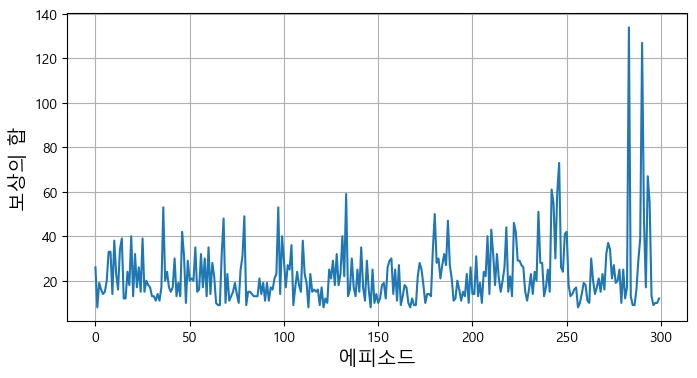

In [100]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("에피소드", fontsize=14)
plt.ylabel("보상의 합", fontsize=14)
plt.grid(True)
plt.show()

In [101]:
animation = show_one_episode(epsilon_greedy_policy)
HTML(animation.to_jshtml())

In [102]:
# 듀얼링 DQN
input_state = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation='elu')(input_states)
hidden2 = tf.keras.layers.Dense(32, activation='elu')(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

In [104]:
# 모델 훈련

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mean_squared_error

target = tf.keras.models.clone_model(model)  # 모델의 아키텍처 복제
target.set_weights(model.get_weights())  # 가중치 복사

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(300):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\r에피소드: {episode + 1}, 스텝: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

에피소드: 300, 스텝: 72, eps: 0.4024

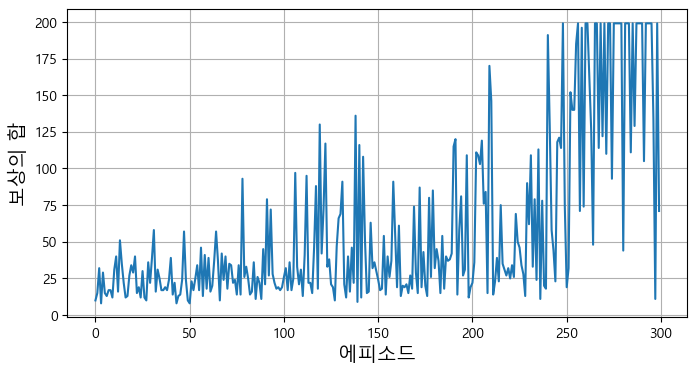

In [105]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("에피소드", fontsize=14)
plt.ylabel("보상의 합", fontsize=14)
plt.grid(True)
plt.show()

In [106]:
animation = show_one_episode(epsilon_greedy_policy)
HTML(animation.to_jshtml())